# Adversarial Examples for MNIST

In this notebook, we use the Fast Gradient Sign Method (FGSM) to generate adversarial examples from the MNIST dataset using the loss function of a trained CNN classifier for supervision. We then explore some methods to try and combat the effectiveness of these adversarial examples.

### Setup

Import packages, define hyperparameters, initialize the data loaders, initialize the CNN classifier, and load the pre-trained model paremeters. The CNN was pre-trained for 10 epochs resulting in 99.1% accuracy on the MNIST test dataset.

In [1]:
import torch
import torchvision
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# relative imports
from cnn import CNN
from dataloader_utils import make_mnist_dataloaders, raw_pytorch_dataset
from data_utils import inputs_with_outputs, compute_pytorch_model_accuracy

BATCH_SIZE = 32
NUM_WORKERS = 1
DATA_DIR = '/tmp/mnist_data/'
NUM_CHAN = 1
NUM_CLASS = 10
CLASSIFIER_MODEL_FILE = '/home/dylan/trained_model_files/pytorch/glados/glados_classifier/glados_classifier_net.pt'

# intialize MNIST dataloaders
train_loader, test_loader = make_mnist_dataloaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    data_dir=DATA_DIR
)

# initialize classifier
classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# load trained cnn classifier paremeters
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

# initialize a cross entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Compute Test Set Accuracy

In [2]:
# compute accuracy on first on test set with non-adversarial examples
test_acc = compute_pytorch_model_accuracy(classifier, test_loader)
print('Test Accuracy: {:.02f}%'.format(test_acc))

Test Accuracy: 99.10%


### Let's Look at Some Non-Adversarial Predictions

We grab a batch from the MNIST test dataset and run it through the classifier to get the class probability predictions for each sample. We can see from the resulting plots that the classifier has very accurate and confident output precitions for each sample. 

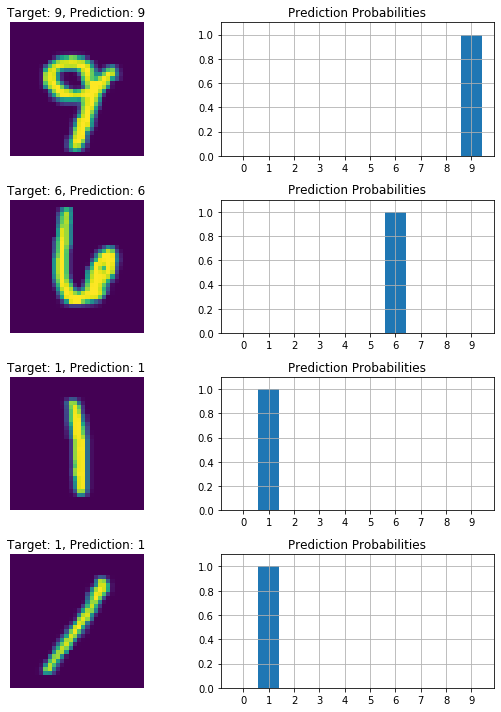

In [10]:
# get a batch from the test loader and keep only first 4 samples
test_batch = iter(test_loader).next()
test_samples, test_labels = test_batch[0][:4], test_batch[1][:4]

# require gradient for input data (need to do this to compute the gradients for inputs dutring backward() call)
test_samples.requires_grad = True

# get predictions
outputs = classifier(test_samples)
pred_prob = torch.nn.functional.softmax(outputs, dim=-1)
pred = torch.argmax(pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
samples_np = np.transpose(test_samples.detach().numpy(), [0, 2, 3, 1])
labels_np = test_labels.detach().numpy()
pred_prob_np = pred_prob.detach().numpy()
pred_np = pred.detach().numpy()

# plot the input samples with the corresponding class prediction probabilities
fig = inputs_with_outputs(samples_np, labels_np, pred_prob_np, pred_np, figsize=(8, 10))

### Let's Make These Samples Adversarial

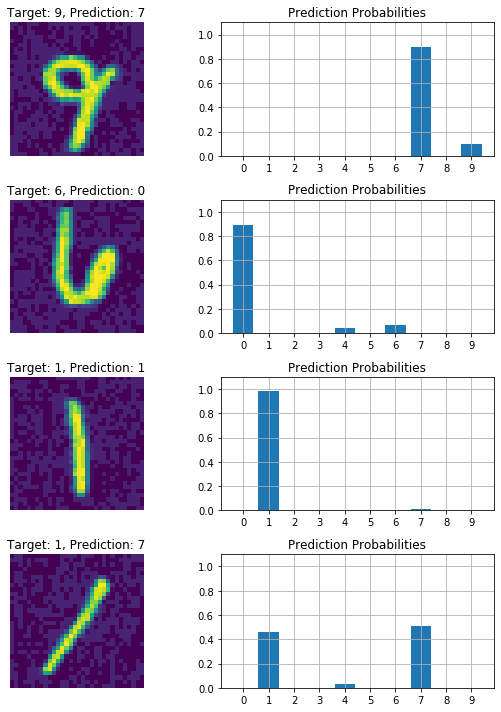

In [11]:
 # compute model outputs on test batch
outputs = classifier(test_samples)

# compute loss on current test batch
loss = loss_fn(outputs, test_labels)

# compute gradients of loss on backward pass
loss.backward()

# get gradients of input data
grads = test_samples.grad

# get sign of gradients
signed_grads = torch.sign(grads)

# perturb test samples using FGSM
adv_test_samples = test_samples + ((0.1) * signed_grads)

# get predictions on adversarial examples
adv_outputs = classifier(adv_test_samples)
adv_pred_prob = torch.nn.functional.softmax(adv_outputs, dim=-1)
adv_pred = torch.argmax(adv_pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
adv_samples_np = np.transpose(adv_test_samples.detach().numpy(), [0, 2, 3, 1])
adv_labels_np = test_labels.detach().numpy()
adv_pred_prob_np = adv_pred_prob.detach().numpy()
adv_pred_np = adv_pred.detach().numpy()

# plot the input samples with the corresponding class prediction probabilities
adv_fig = inputs_with_outputs(adv_samples_np, adv_labels_np, adv_pred_prob_np, adv_pred_np, figsize=(8, 10))

### Create Some Adversarial Sample Datasets


In [5]:
# dictionary to hold adversarial datasets
adv_datasets = {eps: [] for eps in np.arange(0., 0.5, 0.02)}

# list to hold labels
labels = []

# run through all batches of the test loader
for batch in test_loader:
    # parse batch
    test_samples = batch[0]
    test_labels = batch[1]
    
    # append labels
    labels.append(test_labels.detach().numpy())
    
    # require gradient for input data (need to do this to compute the gradients for inputs dutring backward() call)
    test_samples.requires_grad = True
    
    # compute model outputs
    outputs = classifier(test_samples)
    
    # compute loss on current test batch
    loss = loss_fn(outputs, test_labels)

    # compute gradients of loss on backward pass
    loss.backward()

    # get gradients of input data
    grads = test_samples.grad

    # get sign of gradients
    signed_grads = torch.sign(grads)
    
    # range of adversarial perturbution strengths
    for eps in np.arange(0., 0.5, 0.02):

        # perturb test samples using FGSM
        adv_test_samples = test_samples + ((eps) * signed_grads)
        
        # append these adversarial examples to the dictionary
        adv_datasets[eps].append(adv_test_samples.detach().numpy())
        
# concatenate all lists in dataset dictionary to numpy arrays and create a dataloader
adv_datasets = dict(map(lambda x: (x[0], np.concatenate(x[1], axis=0)), adv_datasets.items()))

# concatenate labels to numpy array
labels = np.concatenate(labels, axis=0)

# convert all numpy arrays to pytorch dataloaders
for k, v in adv_datasets.items():
    # create dataset from numpy array
    dataset = raw_pytorch_dataset(v, labels)
    
    # create dataloader from dataset
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS
    )
    
    # replace numpy array in dictionary with dataloader
    adv_datasets[k] = dataloader

### Compute Test Accuracy on All Adversarial Datasets

In [8]:
# get accuracy for each adversarial dataset
test_acc_list = [compute_pytorch_model_accuracy(classifier, v) for k, v in adv_datasets.items()]

# define graph layout
layout = go.Layout(
    title='Test Accuracy as Adversarial Perturbation Strength Increases',
    xaxis_title='Epsilon',
    yaxis_title='Test Accuracy (%)'
)

# construct line graph
fig = go.Figure(
    data=go.Scatter(x=list(adv_datasets.keys()), y=test_acc_list),
    layout=layout
)

fig.show()